In [7]:
"""
Model Evaluation & Analysis
===========================

Check if our models actually work!
"""

import joblib
import json
import pandas as pd
from pathlib import Path

# Load models
models = {}
model_dir = Path('../models')

problem_types = ['has_duplicates', 'has_missing', 'has_outliers', 
                 'has_format_issue', 'has_type_issue']

for ptype in problem_types:
    model_path = model_dir / f'{ptype}_classifier.joblib'
    models[ptype] = joblib.load(model_path)
    print(f"✅ Loaded: {ptype}")

# Load metadata
with open(model_dir / 'classifier_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"\nModel trained at: {metadata['trained_at']}")
print(f"Number of features: {len(metadata['feature_columns'])}")

✅ Loaded: has_duplicates
✅ Loaded: has_missing
✅ Loaded: has_outliers
✅ Loaded: has_format_issue
✅ Loaded: has_type_issue

Model trained at: 2026-02-17T18:12:46.009952
Number of features: 33


In [8]:
"""
Test model on a file it hasn't seen before
"""

import sys
sys.path.append('../ml_pipeline')
from data.feature_extractor import ColumnFeatureExtractor

# Load a test file
test_file = '../data/synthetic/messy/messy_001_titanic_v0.csv'
test_df = pd.read_csv(test_file)

print(f"Testing on: {test_file}")
print(f"Shape: {test_df.shape}")
print(f"\nColumns: {test_df.columns.tolist()}")

# Extract features for each column
print("\n" + "=" * 60)
print("PREDICTIONS")
print("=" * 60)

for col in test_df.columns[:5]:  # Test on first 5 columns only
    print(f"\n📊 Column: {col}")
    
    # Extract features
    extractor = ColumnFeatureExtractor(test_df[col], col)
    features = extractor.extract_all_features()
    
    # Convert to DataFrame (model expects this format)
    feature_row = pd.DataFrame([features])
    feature_row = feature_row[metadata['feature_columns']]  # Select only training features
    
    # Predict each problem type
    predictions = {}
    for ptype in problem_types:
        try:
            # Try to get probability for class 1
            proba = models[ptype].predict_proba(feature_row)[0]
            
            # Check if model has both classes
            if len(proba) == 2:
                prob = proba[1]  # Probability of class 1 (has problem)
            else:
                # Model only learned one class (all 0s or all 1s in training)
                prob = 0.0  # Assume no problem
                
            predictions[ptype] = prob
        except Exception as e:
            # If prediction fails, skip this problem type
            predictions[ptype] = 0.0
    
    # Show top predictions
    sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    
    has_any_predictions = False
    for problem, prob in sorted_predictions:
        if prob > 0.3:  # Only show if somewhat confident
            status = "⚠️ " if prob > 0.5 else "  "
            print(f"  {status}{problem:20s}: {prob:.1%}")
            has_any_predictions = True
    
    if not has_any_predictions:
        print(f"  ✅ No major issues detected")

print("\n" + "=" * 60)
print("Note: This is a simple first model.")
print("Some problem types may not be well-trained due to limited data.")
print("=" * 60)

Testing on: ../data/synthetic/messy/messy_001_titanic_v0.csv
Shape: (980, 15)

Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']

PREDICTIONS

📊 Column: survived
  ⚠️ has_duplicates      : 100.0%
  ⚠️ has_missing         : 100.0%
  ⚠️ has_format_issue    : 100.0%

📊 Column: pclass
  ⚠️ has_duplicates      : 100.0%
  ⚠️ has_missing         : 100.0%
  ⚠️ has_format_issue    : 100.0%

📊 Column: sex
  ⚠️ has_duplicates      : 100.0%
  ⚠️ has_missing         : 100.0%
  ⚠️ has_format_issue    : 99.0%

📊 Column: age
  ⚠️ has_missing         : 100.0%
  ⚠️ has_format_issue    : 100.0%
  ⚠️ has_duplicates      : 99.0%

📊 Column: sibsp
  ⚠️ has_duplicates      : 100.0%
  ⚠️ has_missing         : 100.0%
  ⚠️ has_outliers        : 97.0%
  ⚠️ has_format_issue    : 97.0%

Note: This is a simple first model.
Some problem types may not be well-trained due to limited data.


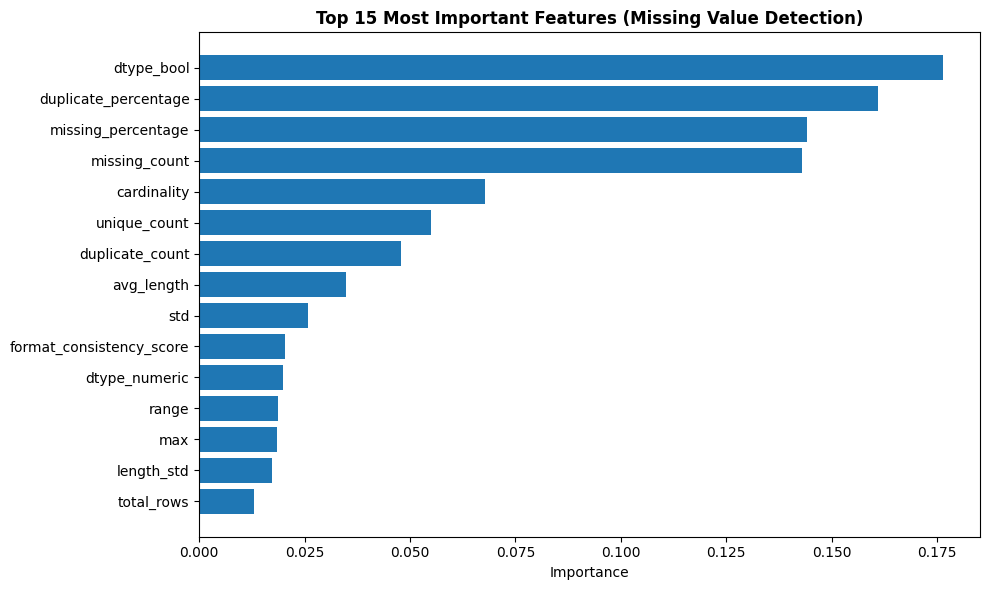


📊 Insight:
These features are most useful for detecting missing values


In [11]:
"""
Which features are most important for predictions?
"""

import matplotlib.pyplot as plt

# Get feature importance from one model
model = models['has_missing']
importances = model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': metadata['feature_columns'],
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features (Missing Value Detection)', 
          fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Insight:")
print("These features are most useful for detecting missing values")


In [12]:
"""
Diagnose the training data quality
"""

# Load the feature dataset
feature_df = pd.read_csv('../data/processed/feature_dataset.csv')

print("📊 TRAINING DATA DIAGNOSIS")
print("=" * 60)

# Check size
print(f"\nDataset size: {feature_df.shape}")
print(f"  Rows (columns analyzed): {feature_df.shape[0]}")
print(f"  Features: {feature_df.shape[1]}")

# Check class distribution
print(f"\n📈 Class Distribution (Problem Types):")
print("=" * 60)

for problem in ['has_duplicates', 'has_missing', 'has_outliers', 'has_format_issue', 'has_type_issue']:
    counts = feature_df[problem].value_counts()
    total = len(feature_df)
    
    print(f"\n{problem}:")
    for class_val, count in counts.items():
        pct = (count / total) * 100
        print(f"  Class {class_val}: {count:4d} ({pct:5.1f}%)")
    
    # Check if severely imbalanced
    if len(counts) == 1:
        print(f"  ⚠️  SEVERE IMBALANCE: Only one class exists!")
    elif min(counts) / max(counts) < 0.1:
        print(f"  ⚠️  IMBALANCED: Minority class < 10%")

# Check feature quality
print(f"\n\n📉 Feature Statistics:")
print("=" * 60)

# Get non-label columns
feature_cols = [col for col in feature_df.columns 
                if col not in ['has_duplicates', 'has_missing', 'has_outliers', 
                              'has_format_issue', 'has_type_issue', 'filename', 'column_name']]

# Check for zero-variance features
zero_var_features = []
for col in feature_cols:
    if feature_df[col].nunique() == 1:
        zero_var_features.append(col)

print(f"Zero-variance features (useless): {len(zero_var_features)}")
if zero_var_features:
    print(f"  Examples: {zero_var_features[:5]}")

# Check for NaN features
nan_features = feature_df[feature_cols].isna().sum()
if nan_features.sum() > 0:
    print(f"\nFeatures with NaN values:")
    print(nan_features[nan_features > 0])

📊 TRAINING DATA DIAGNOSIS

Dataset size: (129, 40)
  Rows (columns analyzed): 129
  Features: 40

📈 Class Distribution (Problem Types):

has_duplicates:
  Class 1:  111 ( 86.0%)
  Class 0:   18 ( 14.0%)

has_missing:
  Class 1:  123 ( 95.3%)
  Class 0:    6 (  4.7%)
  ⚠️  IMBALANCED: Minority class < 10%

has_outliers:
  Class 0:   96 ( 74.4%)
  Class 1:   33 ( 25.6%)

has_format_issue:
  Class 1:  119 ( 92.2%)
  Class 0:   10 (  7.8%)
  ⚠️  IMBALANCED: Minority class < 10%

has_type_issue:
  Class 0:  129 (100.0%)
  ⚠️  SEVERE IMBALANCE: Only one class exists!


📉 Feature Statistics:
Zero-variance features (useless): 7
  Examples: ['contains_special_pct', 'name_contains_name', 'name_contains_email', 'name_contains_phone', 'name_contains_date']
